In [1]:
import numpy as np # linear algebra
import pandas as pd # data proclsessing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
from torchvision.datasets.folder import DatasetFolder, default_loader, IMG_EXTENSIONS
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import Any, Callable, Optional, Tuple
import cv2

C:\Users\LENOVO\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# transform = transforms.Compose(
#     [transforms.RandomCrop(64),
#         transforms.ToTensor(),
#      ])

transform = A.Compose([
    A.RandomCrop(width=100, height=100),
    A.augmentations.geometric.rotate.RandomRotate90(always_apply=False, p=1.0),
    A.augmentations.geometric.transforms.HorizontalFlip(0.5),
    A.augmentations.geometric.transforms.VerticalFlip(0.5),
    A.augmentations.transforms.ImageCompression(quality_lower=70, quality_upper=90),
    A.augmentations.transforms.Downscale(scale_min=0.5, scale_max=.99),
    ToTensorV2()
#     960x960 to 4 480x480 images
])

C:\Users\LENOVO\anaconda3\envs\Pytorch\lib\site-packages\albumentations\augmentations\transforms.py:1554: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class CustomImageFolder(DatasetFolder):
    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = np.array(self.loader(path))
        if self.transform is not None:
            sample = transform(image=sample)['image']
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)

In [5]:
data_dir = 'F:\Forchiemm dataset\dataset'
full_data = CustomImageFolder(root = data_dir, transform = transform)

In [6]:
classes = full_data.classes
print("Classes:",classes)
num_classes = len(full_data.classes)
print("Number of Classes:",num_classes)

Classes: ['D01_Motorola_E3_1', 'D02_LG_OptimusL50_1', 'D03_Wiko_Lenny2_1', 'D04_LG_G3_1', 'D05_Apple_iPhone6s_1', 'D06_LG_G6_1', 'D07_Motorola_Z2Play_1', 'D08_Motorola_G8Plus_1', 'D09_Samsung_GalaxyS4mini_1', 'D10_Samsung_GalaxyJ1_1', 'D11_Samsung_GalaxyJ3_1', 'D12_Samsung_GalaxyStar5280_1', 'D13_Sony_XperiaE5_1', 'D14_Apple_iPhone3_1', 'D15_Samsung_GalaxyA6_1', 'D16_Samsung_GalaxyA6_2', 'D17_Apple_iPhone7_1', 'D18_Samsung_GalaxyS4_1', 'D19_Apple_iPhone8Plus_1', 'D20_Google_Pixel3_1', 'D21_Google_Nexus5_1', 'D22_BQ_AquarisX_1', 'D23_Huawei_P9lite_1', 'D24_Huawei_P8lite_1', 'D25_Huawei_P9lite_2', 'D26_Huawei_P20lite_1', 'D27_Google_PixelXL_1']
Number of Classes: 27


In [7]:
# In 80% & 20% ratio
train_data, test_data = torch.utils.data.random_split(full_data, [3080, 771], generator=torch.Generator().manual_seed(42))  

In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 16, shuffle = False)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26876\3168337840.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  plt.imshow(img.T)


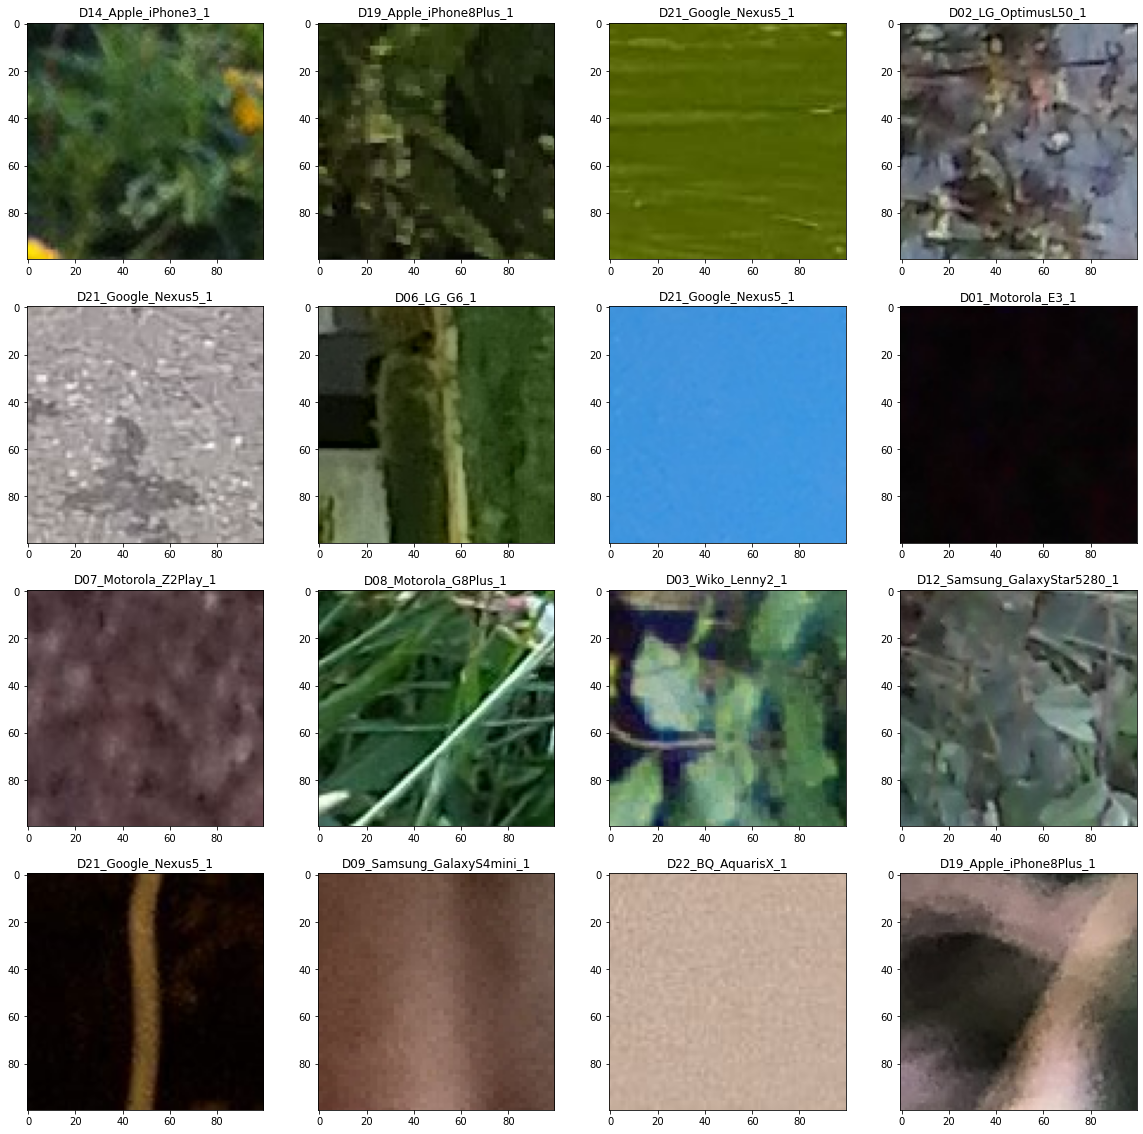

In [9]:
data, labels = next(iter(train_loader))
plt.figure(figsize=(20,20))
for idx, (img, x) in enumerate(zip(data, labels)):
    plt.subplot(4,4,idx+1)
    plt.title(classes[x])
    plt.imshow(img.T)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 128, 5)
        self.fc1 = nn.Linear(25088, 512)
#         self.fc2 = nn.Linear(4096, 200)
#         self.fc3 = nn.Linear(84, 50)
        self.fc_out = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = self.fc_out(x)
        return x


net = Net().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

In [12]:
TrainLoss = []
TrainAcc = []
TestLoss = []
TestAcc = []
num_epochs = 30

In [13]:
def test_accuracy(model, test_data):
    with torch.no_grad():
        testAcc = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device).float()
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            testloss = criterion(outputs, labels)

            # Checking accuracy
            preds = outputs.data.max(dim=1,keepdim=True)[1]
            testAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()
        testAcc = testAcc/len(test_loader.dataset) * 100
        return testAcc

In [ ]:
batches = len(train_loader)
for epoch in range(10):  # loop over the dataset multiple times
    trainAcc = 0
    testAcc = 0
    runningloss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device).float(), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
#             correct = (predictions == labels).sum().item()
#             accuracy = correct / 4
            trainloss = criterion(outputs, labels)
            trainloss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=trainloss.item())
            # Checking accuracy
            preds = outputs.data.max(dim=1,keepdim=True)[1]
            trainAcc += preds.eq(labels.data.view_as(preds)).cpu().sum()

        trainAcc = trainAcc/len(train_loader.dataset) * 100

        testAcc = test_accuracy(net, test_loader)

        print(f"Epoch {epoch+1} =>  Train Loss : {runningloss/batches};   Train Accuracy : {trainAcc}%;   Test Accuracy : {testAcc}%")

        TrainLoss.append((trainloss/batches))
        TrainAcc.append(trainAcc)

        TestAcc.append(testAcc)

print('Finished Training')

Epoch 0:   7%|████▏                                                     | 14/193 [01:15<16:08,  5.41s/batch, loss=5.64]


In [ ]:
TestAcc_lst = []
TrainAcc_lst = []
for i in TestAcc:
    TestAcc_lst.append(i.item())
for i in TrainAcc:
    TrainAcc_lst.append(i.item())

In [ ]:
plt.plot(TrainAcc_lst)
plt.plot(TestAcc_lst)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy of InceptionV3")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

In [ ]:
plt.plot(TrainLoss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss of InceptionV3")
plt.legend(["Training Loss"])
plt.show()

In [ ]:
df = pd.DataFrame({"TrainingAccuracy" : TrainAcc_lst, "TestingAccuracy" : TestAcc_lst, "TrainingLoss": TrainLoss_lst, "TestingLoss": TestLoss_lst})
df.to_csv("epoch_history_InceptionV3.csv", index=False)
torch.save(inception.state_dict(), 'InceptionV3_forchheim.ckpt')
torch.save(optimz.state_dict(), 'InceptionV3_forchheim_optimizer.ckpt')

In [ ]:
from IPython.display import FileLink
FileLink(r'epoch_history_InceptionV3.csv')
FileLink(r'InceptionV3_forchheim.ckpt')
FileLink(r'InceptionV3_forchheim_optimizer.ckpt')